In [1]:
import numpy as np
import torch
import torchio as tio
import nibabel as nib
import random


class Dataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'

    def __init__(self, list_IDs):
        'Initialization'
        # self.labels = labels
        self.list_IDs = list_IDs
        self.img_size = 64

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

    @staticmethod
    def get_augmentation_transform():
        augment = tio.Compose([
            tio.RandomAffine(),
            tio.RandomFlip(p=0.5),
            tio.RandomGamma(p=0.5),
            tio.RandomNoise(p=0.5),
            tio.RandomMotion(p=0.1),
            tio.RandomBiasField(p=0.25)
        ])
        return augment

    def cut_image(self, ID):

        ct = nib.load(f'DATA/CT_{ID}_.nii.gz')
        CT = ct.get_fdata()
        fluence = nib.load(f'DATA/Fluence{ID}_.nii.gz')
        Fluence = fluence.get_fdata()
        body = nib.load(f'DATA/Body/Body{ID}_.nii.gz')
        Body = body.get_fdata()
        mc = nib.load(f'DATA/Dose_MC{ID}_.nii.gz')
        y = mc.get_fdata()

        x_dim, y_dim, z_dim = CT.shape

        new_x = random.randint(0, x_dim - self.img_size)
        new_y = random.randint(0, y_dim - self.img_size)
        new_z = random.randint(0, z_dim - self.img_size)

        new_CT = CT[new_x: new_x + self.img_size, new_y: new_y + self.img_size, new_z: new_z + self.img_size]
        new_Fluence = Fluence[new_x: new_x + self.img_size, new_y: new_y + self.img_size, new_z: new_z + self.img_size]
        new_Body = Body[new_x: new_x + self.img_size, new_y: new_y + self.img_size, new_z: new_z + self.img_size]
        new_y = y[new_x: new_x + self.img_size, new_y: new_y + self.img_size, new_z: new_z + self.img_size]

        CT = nib.Nifti1Image(new_CT, ct.affine)
        Fluence = nib.Nifti1Image(new_Fluence, fluence.affine)
        Body = nib.Nifti1Image(new_Body, body.affine)
        MC = nib.Nifti1Image(new_y, mc.affine)
        output_ct = "Item/CT_.nii.gz"
        output_f = "Item/Fluence_.nii.gz"
        output_b = "Item/Body_.nii.gz"
        output_mc = "Item/MC_.nii.gz"
        nib.save(CT, output_ct)
        nib.save(Fluence, output_f)
        nib.save(Body, output_b)
        nib.save(MC, output_mc)


    @staticmethod
    def get_new_transforms(transformed):

        new_augment = []
        for transformation in transformed.get_applied_transforms():
            if isinstance(transformation, tio.Noise):
                transformation.std['image_fluence'] = transformation.std['image_ct']
                transformation.std['image_body'] = transformation.std['image_ct']
                transformation.std['label'] = transformation.std['image_ct']
                transformation.seed['image_fluence'] = transformation.seed['image_ct']
                transformation.seed['image_body'] = transformation.seed['image_ct']
                transformation.seed['label'] = transformation.seed['image_ct']
            elif isinstance(transformation, tio.Gamma):
                transformation.gamma['image_fluence'] = transformation.gamma['image_ct']
                transformation.gamma['image_body'] = transformation.gamma['image_ct']
                transformation.gamma['label'] = transformation.gamma['image_ct']
            elif isinstance(transformation, tio.Motion):
                transformation.degrees['image_fluence'] = transformation.degrees['image_ct']
                transformation.degrees['image_body'] = transformation.degrees['image_ct']
                transformation.degrees['label'] = transformation.degrees['image_ct']
                transformation.translation['image_fluence'] = transformation.translation['image_ct']
                transformation.translation['image_body'] = transformation.translation['image_ct']
                transformation.translation['label'] = transformation.translation['image_ct']
                transformation.times['image_fluence'] = transformation.times['image_ct']
                transformation.times['image_body'] = transformation.times['image_ct']
                transformation.times['label'] = transformation.times['image_ct']
                transformation.image_interpolation['image_fluence'] = transformation.image_interpolation['image_ct']
                transformation.image_interpolation['image_body'] = transformation.image_interpolation['image_ct']
                transformation.image_interpolation['label'] = transformation.image_interpolation['image_ct']
            elif isinstance(transformation, tio.BiasField):
                transformation.coefficients['image_fluence'] = transformation.coefficients['image_ct']
                transformation.coefficients['image_body'] = transformation.coefficients['image_ct']
                transformation.coefficients['label'] = transformation.coefficients['image_ct']
                transformation.order['image_fluence'] = transformation.order['image_ct']
                transformation.order['image_body'] = transformation.order['image_ct']
                transformation.order['label'] = transformation.order['image_ct']

            new_augment.append(transformation)
        return new_augment

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]

        # Load data and get label

        self.cut_image(ID)

        output_ct = "Item/CT_.nii.gz"
        output_f = "Item/Fluence_.nii.gz"
        output_b = "Item/Body_.nii.gz"
        output_mc = "Item/MC_.nii.gz"

        ct = tio.ScalarImage(output_ct)
        fluence = tio.ScalarImage(output_f)
        body = tio.ScalarImage(output_b)
        mc = tio.ScalarImage(output_mc)

        augment = self.get_augmentation_transform()
        subject = tio.Subject(
            image_ct=ct,
            image_fluence=fluence,
            image_body=body,
            label=mc
        )

        transformed = augment(subject)
        print(transformed.get_applied_transforms())

        new_augment = self.get_new_transforms(transformed)

        new_transform= tio.Compose(new_augment)
        subject = new_transform(subject)
        for t in subject.get_applied_transforms():
            print(t)
            print("_______________________________________")

        return subject

In [2]:
list_IDs = [*range(0, 138, 1)]
data = Dataset(list_IDs)

In [3]:
item = data.__getitem__(6)

[Affine(scales=(1.0954574346542358, 0.9505201578140259, 1.0725237131118774), degrees=(5.406594276428223, 2.5226354598999023, -6.784172058105469), translation=(0.0, 0.0, 0.0), center=image, default_pad_value=minimum, image_interpolation=linear, label_interpolation=nearest, check_shape=True), Flip(axes=(0,)), Gamma(gamma={'image_ct': [0.9154686013322054], 'image_fluence': [1.043341385822717], 'image_body': [0.8745705654197807], 'label': [0.7428751205240832]}), BiasField(coefficients={'image_ct': [-0.2797185182571411, -0.462799608707428, 0.44907981157302856, 0.3153269290924072, -0.3365885615348816, 0.1813315749168396, 0.009413540363311768, 0.30557817220687866, -0.3637530207633972, 0.29455798864364624, 0.15254026651382446, -0.05872797966003418, 0.1862507462501526, -0.08856511116027832, -0.36892765760421753, -0.3280124068260193, -0.26316994428634644, -0.07234102487564087, 0.06911170482635498, 0.42790836095809937], 'image_fluence': [0.20706069469451904, 0.1403067708015442, -0.150798678398132

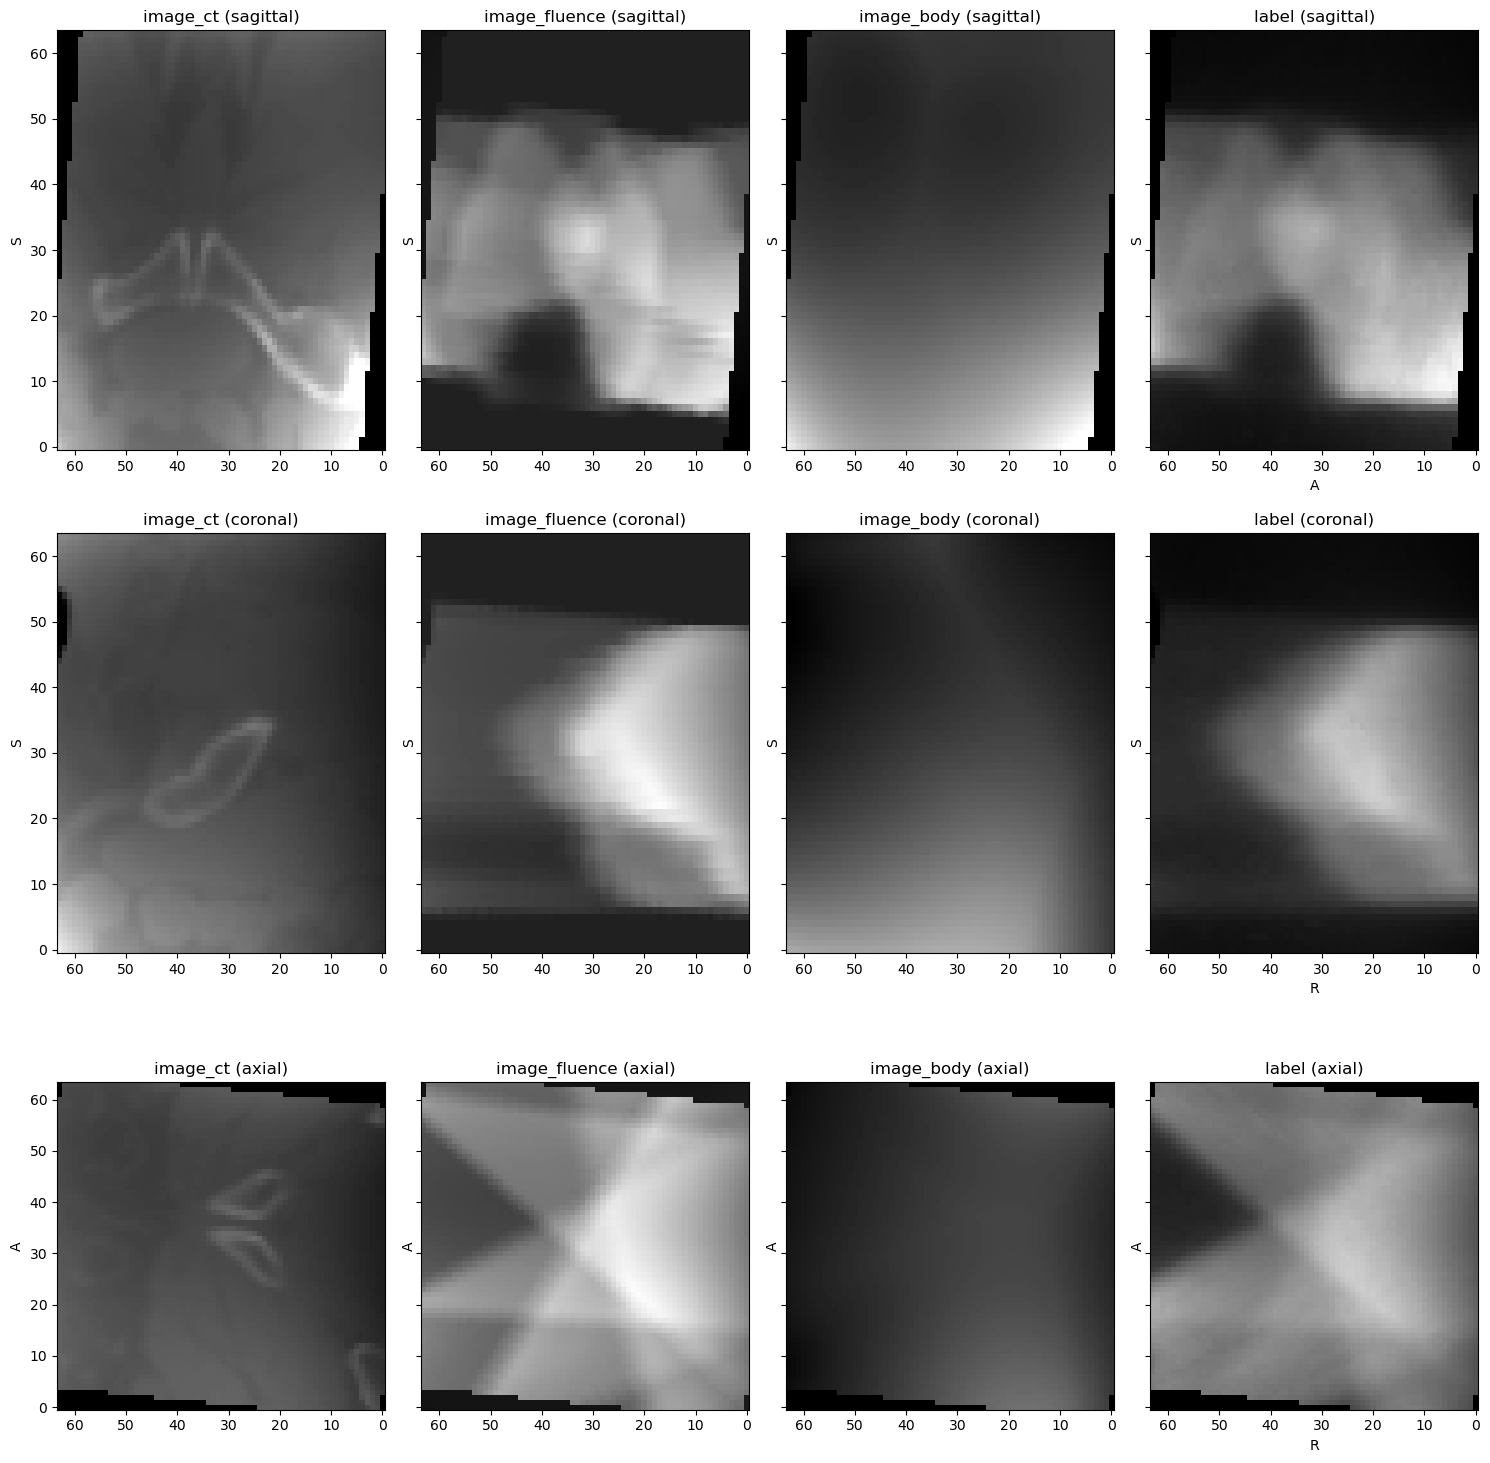

In [4]:
item.plot(figsize=(15,15))